In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# Define the exact solution u = H
def exact_solution_u(x, t):
    return torch.sin(x)*torch.cos(t)

def initial_condition_u(x):
    return torch.sin(x) 

In [3]:
# Define the exact solution p = E
def exact_solution_p(x, t):
    return -torch.sin(t)*torch.cos(x)

def initial_condition_p(x):
    return 0.0*torch.sin(x) 

In [4]:
# assigning number of points
initial_pts = 200
left_boundary_pts = 200 
right_boundary_pts = 200
residual_pts = 1000

In [5]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1)
w_init = torch.cat([u_init, p_init],1)



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, tb_left ],1)
u_b_l = exact_solution_u(xb_left, tb_left)
p_b_l = exact_solution_p(xb_left, tb_left)
w_b_l = torch.cat([u_b_l, p_b_l],1)



xb_right = pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1)
u_b_r = exact_solution_u(xb_right, tb_right)
p_b_r = exact_solution_p(xb_right, tb_right)
w_b_r = torch.cat([u_b_r, p_b_r],1)

x_interior = pi*torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, w_init, b_left,  b_right), batch_size=200, shuffle=False)

In [6]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [7]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = w_init.shape[1], n_hidden_layers=4, neurons=20)


In [8]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
#print(my_network(init))

In [9]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [10]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, w_initial, bd_left,  bd_right) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:,0].reshape(-1,1)
                p_initial_pred_ = w_initial_pred_[:,1].reshape(-1,1)
                
                
                # with derivative
                inpu = torch.ones(initial_pts, 1 )
                
                grad_u_ini = torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                
                u_initial_t = grad_u_ini[:, 1]
                
                
                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]
                
                p_initial_t = grad_p_ini[:, 1]
                
                
                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:,0].reshape(-1,1)
                p_bd_left_pred_ = w_bd_left_pred_[:,1].reshape(-1,1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:,0].reshape(-1,1)
                p_bd_right_pred_ = w_bd_right_pred_[:,1].reshape(-1,1)
                
                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                u_hat = w_hat[:,0].reshape(-1,1)
                p_hat = w_hat[:,1].reshape(-1,1)
                inputs = torch.ones(residual_pts, 1 )
                inputs2 = torch.ones(residual_pts, 1)
                grad_u_hat = torch.autograd.grad(u_hat.reshape(-1,1), interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_x = grad_u_hat[:, 0].reshape(-1,1)
                
               
                
                grad_p_hat = torch.autograd.grad(p_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                
                p_x = grad_p_hat[:, 0].reshape(-1,1)
                
              
                
                
                
                #grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                #u_xx = grad_grad_u_x[:, 0]
                u_t = grad_u_hat[:, 1].reshape(-1,1)
                
               
                
                p_t = grad_p_hat[:,1].reshape(-1,1)
             
                
                
                
                # Item 1. below
                loss1 = torch.mean((u_initial_pred_.reshape(-1, ) - w_initial[:,0].reshape(-1, ))**p) + torch.mean((u_t.reshape(-1, ) + p_x.reshape(-1, ))**p)+torch.mean((u_bd_left_pred_.reshape(-1,)- u_b_l.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,)- u_b_r.reshape(-1,))**p)
                loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:,1].reshape(-1, ))**p)+ torch.mean((2*p_t.reshape(-1, )  + u_x.reshape(-1, ) + torch.cos(interior[:, 0])*torch.cos(interior[:, 1]))**p)+torch.mean((p_bd_left_pred_.reshape(-1,) - p_b_l.reshape(-1,))**p) + torch.mean((p_bd_right_pred_.reshape(-1,)- p_b_r.reshape(-1,))**p)
                loss = loss1 + loss2
                #loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))
 
                
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [11]:
n_epochs = 1500
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  9.345173835754395
################################  1  ################################
Loss:  9.099297523498535
################################  2  ################################
Loss:  7.813821792602539
################################  3  ################################
Loss:  6.557640075683594
################################  4  ################################
Loss:  5.538811683654785
################################  5  ################################
Loss:  4.723111629486084
################################  6  ################################
Loss:  4.047318458557129
################################  7  ################################
Loss:  3.4740171432495117
################################  8  ################################
Loss:  2.9868836402893066
################################  9  ################################
Loss:  2.5784356594085693
################################  10  #########

Loss:  0.00474820239469409
################################  104  ################################
Loss:  0.004570364486426115
################################  105  ################################
Loss:  0.004401831887662411
################################  106  ################################
Loss:  0.004244422074407339
################################  107  ################################
Loss:  0.004092702176421881
################################  108  ################################
Loss:  0.0039487723261117935
################################  109  ################################
Loss:  0.003808117937296629
################################  110  ################################
Loss:  0.003671382088214159
################################  111  ################################
Loss:  0.003539100755006075
################################  112  ################################
Loss:  0.003409006167203188
################################  113  ################################


Loss:  0.0005191080272197723
################################  190  ################################
Loss:  0.0005083424039185047
################################  191  ################################
Loss:  0.000497855304274708
################################  192  ################################
Loss:  0.00048780968063510954
################################  193  ################################
Loss:  0.00047849409747868776
################################  194  ################################
Loss:  0.000470069790026173
################################  195  ################################
Loss:  0.000461832620203495
################################  196  ################################
Loss:  0.00045422400580719113
################################  197  ################################
Loss:  0.00044679309939965606
################################  198  ################################
Loss:  0.00043968757381662726
################################  199  #####################

Loss:  0.00015067831554915756
################################  290  ################################
Loss:  0.00014893693150952458
################################  291  ################################
Loss:  0.00014704704517498612
################################  292  ################################
Loss:  0.00014519153046421707
################################  293  ################################
Loss:  0.000143254132126458
################################  294  ################################
Loss:  0.00014129493501968682
################################  295  ################################
Loss:  0.00013929627311881632
################################  296  ################################
Loss:  0.00013719830894842744
################################  297  ################################
Loss:  0.00013511907309293747
################################  298  ################################
Loss:  0.00013301422586664557
################################  299  ###############

Loss:  6.40836515231058e-05
################################  383  ################################
Loss:  6.376765668392181e-05
################################  384  ################################
Loss:  6.346653390210122e-05
################################  385  ################################
Loss:  6.313961057458073e-05
################################  386  ################################
Loss:  6.285101699177176e-05
################################  387  ################################
Loss:  6.251808372326195e-05
################################  388  ################################
Loss:  6.215939356479794e-05
################################  389  ################################
Loss:  6.172984285512939e-05
################################  390  ################################
Loss:  6.12564108450897e-05
################################  391  ################################
Loss:  6.0778664192184806e-05
################################  392  ########################

Loss:  4.1331673855893314e-05
################################  481  ################################
Loss:  4.121415258850902e-05
################################  482  ################################
Loss:  4.111620000912808e-05
################################  483  ################################
Loss:  4.100421938346699e-05
################################  484  ################################
Loss:  4.08714113291353e-05
################################  485  ################################
Loss:  4.0716491639614105e-05
################################  486  ################################
Loss:  4.057761907461099e-05
################################  487  ################################
Loss:  4.040928979520686e-05
################################  488  ################################
Loss:  4.024021473014727e-05
################################  489  ################################
Loss:  4.0058319427771494e-05
################################  490  #####################

Loss:  2.7495130780152977e-05
################################  582  ################################
Loss:  2.7413152565713972e-05
################################  583  ################################
Loss:  2.733646033448167e-05
################################  584  ################################
Loss:  2.724678961385507e-05
################################  585  ################################
Loss:  2.7153328119311482e-05
################################  586  ################################
Loss:  2.7062011213274673e-05
################################  587  ################################
Loss:  2.695541115826927e-05
################################  588  ################################
Loss:  2.6868749046116136e-05
################################  589  ################################
Loss:  2.6767458621179685e-05
################################  590  ################################
Loss:  2.6666722988011315e-05
################################  591  ################

Loss:  2.186316851293668e-05
################################  684  ################################
Loss:  2.182420575991273e-05
################################  685  ################################
Loss:  2.1781859686598182e-05
################################  686  ################################
Loss:  2.1737847418989986e-05
################################  687  ################################
Loss:  2.1692940208595246e-05
################################  688  ################################
Loss:  2.1647130779456347e-05
################################  689  ################################
Loss:  2.1599405954475515e-05
################################  690  ################################
Loss:  2.1553554688580334e-05
################################  691  ################################
Loss:  2.1507723431568593e-05
################################  692  ################################
Loss:  2.1461750293383375e-05
################################  693  ###############

Loss:  1.6819343727547675e-05
################################  776  ################################
Loss:  1.67795478773769e-05
################################  777  ################################
Loss:  1.6740010323701426e-05
################################  778  ################################
Loss:  1.6699796105967835e-05
################################  779  ################################
Loss:  1.666686512180604e-05
################################  780  ################################
Loss:  1.6634989151498303e-05
################################  781  ################################
Loss:  1.660425368754659e-05
################################  782  ################################
Loss:  1.6572894310229458e-05
################################  783  ################################
Loss:  1.654044899623841e-05
################################  784  ################################
Loss:  1.6506110114278272e-05
################################  785  ##################

Loss:  1.2582383533299435e-05
################################  871  ################################
Loss:  1.2562572010210715e-05
################################  872  ################################
Loss:  1.2540605894173495e-05
################################  873  ################################
Loss:  1.2519081792561337e-05
################################  874  ################################
Loss:  1.2497498573793564e-05
################################  875  ################################
Loss:  1.2473196875362191e-05
################################  876  ################################
Loss:  1.2446645996533334e-05
################################  877  ################################
Loss:  1.2416656318237074e-05
################################  878  ################################
Loss:  1.2385175068629906e-05
################################  879  ################################
Loss:  1.2355227227089927e-05
################################  880  #############

################################  974  ################################
Loss:  9.363364370074123e-06
################################  975  ################################
Loss:  9.342435077996925e-06
################################  976  ################################
Loss:  9.31741942622466e-06
################################  977  ################################
Loss:  9.296301868744195e-06
################################  978  ################################
Loss:  9.274343028664589e-06
################################  979  ################################
Loss:  9.252410563931335e-06
################################  980  ################################
Loss:  9.231303010892589e-06
################################  981  ################################
Loss:  9.20941965887323e-06
################################  982  ################################
Loss:  9.187971954816021e-06
################################  983  ################################
Loss:  9.169212717097

Loss:  6.8955941969761625e-06
################################  1076  ################################
Loss:  6.886361006763764e-06
################################  1077  ################################
Loss:  6.874420705571538e-06
################################  1078  ################################
Loss:  6.859483164589619e-06
################################  1079  ################################
Loss:  6.841548838565359e-06
################################  1080  ################################
Loss:  6.828003279224504e-06
################################  1081  ################################
Loss:  6.812408173573203e-06
################################  1082  ################################
Loss:  6.794642104068771e-06
################################  1083  ################################
Loss:  6.775834208383458e-06
################################  1084  ################################
Loss:  6.756155926268548e-06
################################  1085  ############

Loss:  5.2452987802098505e-06
################################  1174  ################################
Loss:  5.238817720965017e-06
################################  1175  ################################
Loss:  5.232421244727448e-06
################################  1176  ################################
Loss:  5.226166649663355e-06
################################  1177  ################################
Loss:  5.219927516009193e-06
################################  1178  ################################
Loss:  5.214295470068464e-06
################################  1179  ################################
Loss:  5.207027243159246e-06
################################  1180  ################################
Loss:  5.200927262194455e-06
################################  1181  ################################
Loss:  5.193624019739218e-06
################################  1182  ################################
Loss:  5.1856677600881085e-06
################################  1183  ###########

Loss:  4.4530506784212776e-06
################################  1261  ################################
Loss:  4.446063030627556e-06
################################  1262  ################################
Loss:  4.441598321136553e-06
################################  1263  ################################
Loss:  4.436298695509322e-06
################################  1264  ################################
Loss:  4.4302123569650576e-06
################################  1265  ################################
Loss:  4.423172867973335e-06
################################  1266  ################################
Loss:  4.4160096877021715e-06
################################  1267  ################################
Loss:  4.408728727867128e-06
################################  1268  ################################
Loss:  4.40110670751892e-06
################################  1269  ################################
Loss:  4.393500603327993e-06
################################  1270  ###########

Loss:  4.055911176692462e-06
################################  1358  ################################
Loss:  4.051345058542211e-06
################################  1359  ################################
Loss:  4.046669801027747e-06
################################  1360  ################################
Loss:  4.041850843350403e-06
################################  1361  ################################
Loss:  4.037285179947503e-06
################################  1362  ################################
Loss:  4.032649485452566e-06
################################  1363  ################################
Loss:  4.0279346649185754e-06
################################  1364  ################################
Loss:  4.022296707262285e-06
################################  1365  ################################
Loss:  4.017965693492442e-06
################################  1366  ################################
Loss:  4.013500074506737e-06
################################  1367  ############

Loss:  3.6496726352197584e-06
################################  1444  ################################
Loss:  3.645606966529158e-06
################################  1445  ################################
Loss:  3.6415135582501534e-06
################################  1446  ################################
Loss:  3.63836716132937e-06
################################  1447  ################################
Loss:  3.6347960303828586e-06
################################  1448  ################################
Loss:  3.63098524758243e-06
################################  1449  ################################
Loss:  3.6269534575694706e-06
################################  1450  ################################
Loss:  3.6228448152542114e-06
################################  1451  ################################
Loss:  3.6181786526867654e-06
################################  1452  ################################
Loss:  3.6150217965769116e-06
################################  1453  ########

In [12]:
# saving and loading Model
FILE = "maxwell1D_2.pth"
torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [13]:
# saving and loading Model (this model with reported results)
#FILE = "second.pth"
#torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [14]:
x_test = torch.linspace(0, pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)

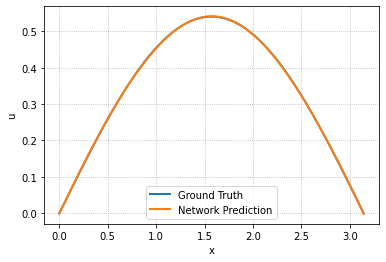

In [15]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [16]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.0005961208444205113 %


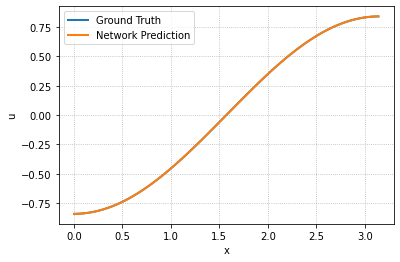

In [17]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [18]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  7.05951777035807e-05 %


In [19]:
# for ploting

In [20]:
model = my_network
x_test = pi*torch.rand(100000).reshape(-1,1)
t_test = torch.rand(100000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test,t_test).reshape(-1,1)
p_test = exact_solution_p(x_test,t_test).reshape(-1,1)
u_test_pred = my_network(test)
u_pred = u_test_pred[:, 0].reshape(-1,1)

u_pred1 = u_test_pred[:, 1].reshape(-1,1)


relative_error = torch.abs(u_pred- u_test)

relative_error1 = torch.abs(u_pred1- p_test)
u_pred = u_pred.detach().numpy()
x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
p_pred = u_pred1.detach().numpy()
relative_error = relative_error.detach().numpy()
relative_error1 = relative_error1.detach().numpy()

In [21]:

x_test = x_test.reshape(-1,)
t_test = t_test.reshape(-1,)

u_pred = u_pred.reshape(-1,)
p_pred = p_pred.reshape(-1,)

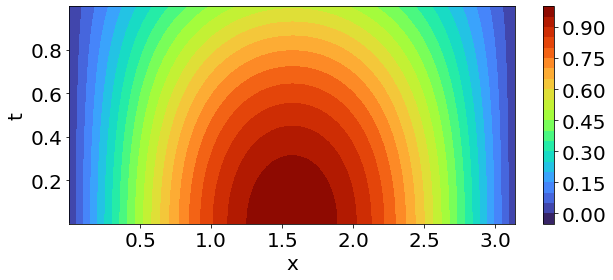

In [22]:
plt.rcParams['figure.figsize'] = [10, 4]


CS = plt.tricontourf(x_test, t_test, u_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#plt.savefig('timo_u.png', dpi = 300, bbox_inches = "tight")

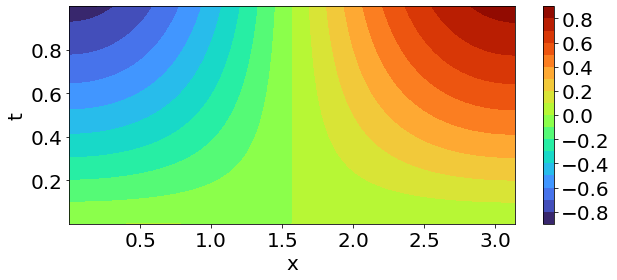

In [23]:
CS = plt.tricontourf(x_test, t_test, p_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('timo_p.png', dpi = 300, bbox_inches = "tight")

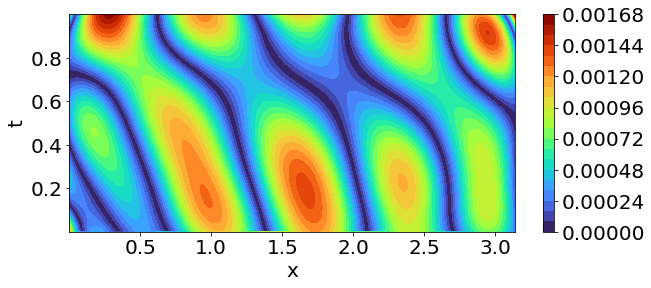

In [24]:

x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
relative_error = relative_error.reshape(-1,)




CS = plt.tricontourf(x_test, t_test, relative_error, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('relative_error_timo_u.png', dpi = 300, bbox_inches = "tight")

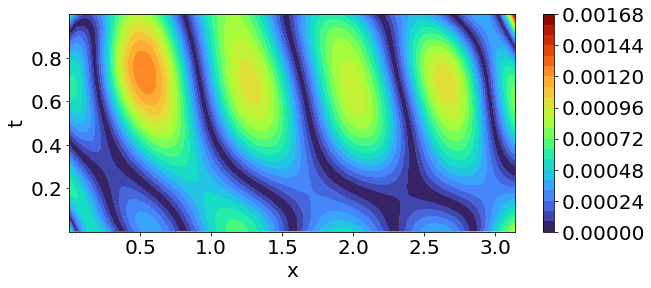

In [25]:



relative_error1 = relative_error1.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error1, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('relative_error_timo_p.png', dpi = 300, bbox_inches = "tight")